In [2]:
from collections import namedtuple
from math import sqrt 
from random import randint

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.distributions.empirical_distribution import ECDF
from statistics import covariance, correlation
from fitter import Fitter, get_common_distributions

In [3]:
Experiment = namedtuple("Experiment", ["crash_time", 
                                       "z",
                                       "maintenance_queue_times", 
                                       "workers_utilization", 
                                       "lt_3"], 
                                       defaults=[None] * 5)

Organizing the collected data in a dictionary

In [4]:
with open('results.txt') as f:
    experiments = f.read().split('---')[:-1]

EXPERIMENTS = {}

for e in experiments:

    e = e.strip().split("\n")
    times = []
    d = {}
    for line in e[:-6]:
        line = line.split()
        if line[0] == "IN":
            d[line[1]] = float(line[2])
        elif line[0] == "OUT":
            times.append(float(line[2]) - d[line[1]])
            del(d[line[1]])
        else: 
            raise AssertionError()
        
    initial_spares = int(e[-2])
    n_workers = int(e[-4])
    if (initial_spares, n_workers) not in EXPERIMENTS.keys():
        EXPERIMENTS[(initial_spares, n_workers)] = []
    
    EXPERIMENTS[(initial_spares, n_workers)].append(
        Experiment( crash_time=float(e[-1]),
                    z=float(e[-3]),
                    workers_utilization=float(e[-5]),
                    
                    maintenance_queue_times=tuple(times),
                    lt_3=int(e[-6])))

In [5]:
all_param_configurations = sorted(list(EXPERIMENTS.keys()))
all_param_configurations

[(6, 1), (6, 2), (6, 3), (7, 1), (7, 2), (7, 3), (8, 1), (8, 2), (8, 3)]

### <span style="color:red">INTERVAL ESTIMATES on the expected crash time of the system</span>

Reminder :

Z is a standard normal, mean = 0 and std = 1

P[ Z < -1.96 ] = 0.025&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;P[ X < -2.3263 ] = 0.01&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;P[ X < -2.5758 ] = 0.005

P[ Z ≥ &nbsp;&nbsp;1.96 ] = 0.025&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;P[ X ≥ &nbsp;&nbsp;2.3263 ] = 0.01&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;P[ X ≥ &nbsp;&nbsp;2.5758 ] = 0.005

In [6]:
k = 500
print(f'# of runs : {k:3d} , with prob 95%\n')

for s,w in all_param_configurations:

    X = [e.crash_time for e in EXPERIMENTS[s,w]][:k]
    interval = 1.96 * np.std(X, ddof=1) / sqrt(len(X))
    reliability = np.var(X, ddof=1) / len(X)
    print(f'By sample mean : E[ crash_time_s{s}_w{w} ] = {np.mean(X):8.2f} ± {interval:6.2f} , reliability in terms of expected MSE: {reliability:8.2f}')

# of runs : 500 , with prob 95%

By sample mean : E[ crash_time_s6_w1 ] =   148.69 ±  12.27 , reliability in terms of expected MSE:    39.18
By sample mean : E[ crash_time_s6_w2 ] =   267.05 ±  22.20 , reliability in terms of expected MSE:   128.31
By sample mean : E[ crash_time_s6_w3 ] =   294.77 ±  26.84 , reliability in terms of expected MSE:   187.46
By sample mean : E[ crash_time_s7_w1 ] =   230.95 ±  18.07 , reliability in terms of expected MSE:    85.02
By sample mean : E[ crash_time_s7_w2 ] =   681.94 ±  65.13 , reliability in terms of expected MSE:  1104.19
By sample mean : E[ crash_time_s7_w3 ] =   646.07 ±  64.71 , reliability in terms of expected MSE:  1090.06
By sample mean : E[ crash_time_s8_w1 ] =   343.60 ±  32.22 , reliability in terms of expected MSE:   270.25
By sample mean : E[ crash_time_s8_w2 ] =  1471.05 ± 149.88 , reliability in terms of expected MSE:  5847.56
By sample mean : E[ crash_time_s8_w3 ] =  1634.82 ± 157.11 , reliability in terms of expected MSE:  642

### <span style="color:red">Empirical distribution of the crash time of the system</span>

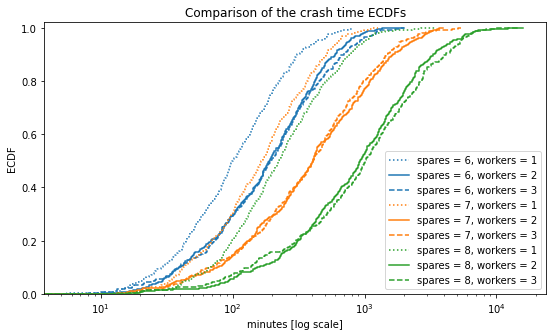

In [7]:
fig, ax = plt.subplots(figsize=(9,5))

for s,w in all_param_configurations:
    color = 'tab:blue' if s == 6 else ('tab:orange' if s == 7 else 'tab:green')
    linestyle = 'solid' if w == 2 else ('dashed' if w == 3 else 'dotted')
    sns.ecdfplot([e.crash_time for e in EXPERIMENTS[s,w]], color=color, linestyle=linestyle, label=f'spares = {s}, workers = {w}')

ax.set_ylim(0,1.02)
ax.set_xscale('log')
ax.set_xlabel('minutes [log scale]')
ax.set_ylabel('ECDF')
ax.set_title('Comparison of the crash time ECDFs')
plt.legend(loc='lower right')
plt.show()

In [8]:
h = 8
for s,w in all_param_configurations:
    print(f'With {s} spares and {w} workers, P[ "the system crashes before {h} hours of activity" ] ≈ {ECDF([e.crash_time for e in EXPERIMENTS[s,w]])(h * 60):.2f}')

With 6 spares and 1 workers, P[ "the system crashes before 8 hours of activity" ] ≈ 0.95
With 6 spares and 2 workers, P[ "the system crashes before 8 hours of activity" ] ≈ 0.85
With 6 spares and 3 workers, P[ "the system crashes before 8 hours of activity" ] ≈ 0.81
With 7 spares and 1 workers, P[ "the system crashes before 8 hours of activity" ] ≈ 0.88
With 7 spares and 2 workers, P[ "the system crashes before 8 hours of activity" ] ≈ 0.57
With 7 spares and 3 workers, P[ "the system crashes before 8 hours of activity" ] ≈ 0.56
With 8 spares and 1 workers, P[ "the system crashes before 8 hours of activity" ] ≈ 0.78
With 8 spares and 2 workers, P[ "the system crashes before 8 hours of activity" ] ≈ 0.31
With 8 spares and 3 workers, P[ "the system crashes before 8 hours of activity" ] ≈ 0.28


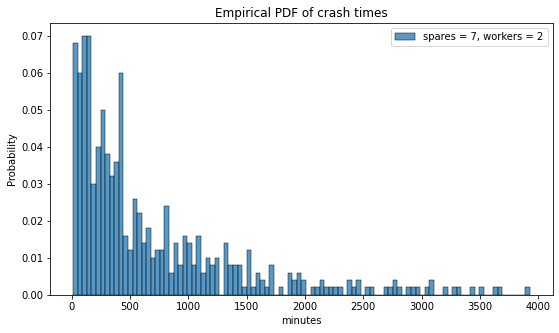

In [9]:
s, w = 7, 2
fig, ax = plt.subplots(figsize=(9,5))
sns.histplot([e.crash_time for e in EXPERIMENTS[7,2]], stat = "probability", bins=100, label=f'spares = {s}, workers = {w}')
ax.set_xlabel('minutes')
plt.title('Empirical PDF of crash times')
plt.legend()
plt.show()

Searching for a theoretical distribution that looks similar to my empirical one

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,0.000002,1897.064037,1909.707861,inf,0.041507,3.456017e-01
lognorm,0.000002,1879.395810,1892.039635,inf,0.040371,3.789447e-01
expon,0.000002,1890.362604,1898.791820,inf,0.082021,2.251564e-03
exponpow,0.000003,1867.482539,1880.126364,inf,0.089637,6.036910e-04
powerlaw,0.000006,1725.518586,1738.162411,inf,0.201946,2.367080e-18


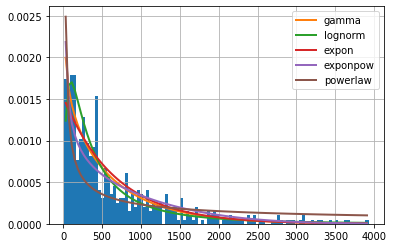

In [10]:
s, w = 7, 2
f = Fitter([e.crash_time for e in EXPERIMENTS[s,w]], distributions=get_common_distributions())
f.fit()
f.summary()

### <span style="color:red">VARIANCE REDUCTION BY CONTROL VARIATES to estimate the expected crash time of the system</span>

The random variable Z is used as a control variate

In [11]:
s, w = 7, 2
X = np.array([e.crash_time  for e in EXPERIMENTS[(s,w)]])
Z = np.array([e.z           for e in EXPERIMENTS[(s,w)]])

Y = X + (-covariance(X, Z) / (0.3 ** 2)) * Z

print(f'# of runs : {len(X):3d} , with prob 95%\n')
print(f'By sample mean on X                               :  E[ crash_time_s{s}_w{w} ] = {np.mean(X):6.2f} ± {1.96 * np.std(X, ddof=1) / sqrt(len(X)):6.2f}')
print(f'By sample mean on Y, using Z as a control variate :  E[ crash_time_s{s}_w{w} ] = {np.mean(Y):6.2f} ± {1.96 * np.std(Y, ddof=1) / sqrt(len(Y)):6.2f}\n')
print(f'VAR[Y] / VAR[X] = 1 - CORR[X,Z]^2 = {np.var(Y, ddof=1) / np.var(X, ddof=1):.2f}')
print(f'CORR[X,Z] = {correlation(X,Z):.2f}')

# of runs : 500 , with prob 95%

By sample mean on X                               :  E[ crash_time_s7_w2 ] = 681.94 ±  65.13
By sample mean on Y, using Z as a control variate :  E[ crash_time_s7_w2 ] = 670.54 ±  59.45

VAR[Y] / VAR[X] = 1 - CORR[X,Z]^2 = 0.83
CORR[X,Z] = -0.41


### <span style="color:red">INTERVAL ESTIMATES on the waiting times in maintenance queue</span>

In [12]:
k = 300
print(f'# of runs : {k:3d} , with prob 98%\n')

for s,w in all_param_configurations:

    pq = []
    tq_averages = []

    for e in EXPERIMENTS[s,w][:k]:
        t = e.maintenance_queue_times
        t_pos = [x for x in t if x > 0]
        pq.append(len(t_pos)/len(t))
        if len(t_pos) > 0:
            tq_averages.append(np.mean(t_pos))

    interval = 2.3263 * np.std(pq, ddof=1) / sqrt(len(pq))
    reliability = np.var(pq, ddof=1) / len(pq)
    print(f'By sample mean : E[ P_q           , s{s}_w{w} ] = {np.mean(pq):6.2f} ± {interval:4.2f} , reliability in terms of expected MSE: {reliability:8.9f}')

    if len(tq_averages) > 0:
        interval = 2.3263 * np.std(tq_averages, ddof=1) / sqrt(len(tq_averages))
        reliability = np.var(tq_averages, ddof=1) / len(tq_averages)
        print(f'By sample mean : E[ T_q | P_q = 1 , s{s}_w{w} ] = {np.mean(tq_averages):6.2f} ± {interval:4.2f} , reliability in terms of expected MSE: {reliability:8.9f}\n')
    else:
        print()

# of runs : 300 , with prob 98%

By sample mean : E[ P_q           , s6_w1 ] =   0.00 ± 0.00 , reliability in terms of expected MSE: 0.000000000

By sample mean : E[ P_q           , s6_w2 ] =   0.17 ± 0.01 , reliability in terms of expected MSE: 0.000040635
By sample mean : E[ T_q | P_q = 1 , s6_w2 ] =   2.03 ± 0.10 , reliability in terms of expected MSE: 0.001858038

By sample mean : E[ P_q           , s6_w3 ] =   0.21 ± 0.02 , reliability in terms of expected MSE: 0.000058712
By sample mean : E[ T_q | P_q = 1 , s6_w3 ] =   2.85 ± 0.14 , reliability in terms of expected MSE: 0.003876290

By sample mean : E[ P_q           , s7_w1 ] =   0.00 ± 0.00 , reliability in terms of expected MSE: 0.000000000

By sample mean : E[ P_q           , s7_w2 ] =   0.22 ± 0.01 , reliability in terms of expected MSE: 0.000035426
By sample mean : E[ T_q | P_q = 1 , s7_w2 ] =   2.08 ± 0.07 , reliability in terms of expected MSE: 0.000926661

By sample mean : E[ P_q           , s7_w3 ] =   0.27 ± 0.02 , reli

### <span style="color:red">INTERVAL ESTIMATES on workers utilization</span>

Utilization is the fraction of time a worker was busy during the experiment, its value lies in the range [0, 1].

For each simulation run we collected the mean of the utilization of the workers.

In [13]:
k = 100
print(f'# of runs : {k:3d} , with prob 99%\n')

for s,w in all_param_configurations:

    X = [e.workers_utilization for e in EXPERIMENTS[s,w]][:k]
    interval = 2.5758 * np.std(X, ddof=1) / sqrt(len(X))
    reliability = np.var(X, ddof=1) / len(X)
    print(f'By sample mean : E[ workers utilization, s{s}_w{w} ] = {np.mean(X):4.2f} ± {interval:4.2f} , reliability in terms of expected MSE: {reliability:8.9f}')

# of runs : 100 , with prob 99%

By sample mean : E[ workers utilization, s6_w1 ] = 0.75 ± 0.03 , reliability in terms of expected MSE: 0.000176584
By sample mean : E[ workers utilization, s6_w2 ] = 0.49 ± 0.03 , reliability in terms of expected MSE: 0.000170468
By sample mean : E[ workers utilization, s6_w3 ] = 0.34 ± 0.02 , reliability in terms of expected MSE: 0.000085747
By sample mean : E[ workers utilization, s7_w1 ] = 0.80 ± 0.03 , reliability in terms of expected MSE: 0.000122161
By sample mean : E[ workers utilization, s7_w2 ] = 0.48 ± 0.03 , reliability in terms of expected MSE: 0.000102647
By sample mean : E[ workers utilization, s7_w3 ] = 0.35 ± 0.02 , reliability in terms of expected MSE: 0.000078486
By sample mean : E[ workers utilization, s8_w1 ] = 0.80 ± 0.03 , reliability in terms of expected MSE: 0.000099372
By sample mean : E[ workers utilization, s8_w2 ] = 0.51 ± 0.02 , reliability in terms of expected MSE: 0.000073506
By sample mean : E[ workers utilization, s8_w3 

### <span style="color:red">Application of BOOTSTRAPPING technique</span>

We do a bootstrap estimate, considering only 50 runs, of

MEDIAN [ L ] and STD [ L ] , where L = # times in a simulation run in which the # spares becomes < 3

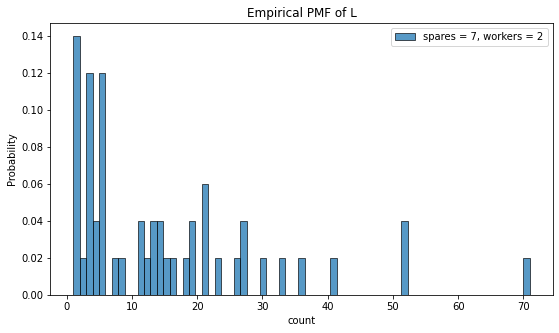

Performing 50 runs only :

Estimate f(l) of MEDIAN[ L ] : 11.00
Estimate g(l) of    STD[ L ] : 15.37

Estimate of E[ MSE between f(l) and θ(F) ] : 0.171
Estimate of E[ MSE between g(l) and θ(F) ] : 0.142


In [39]:
k = 50

def inverse_ECDF(v, k):
    return [v[randint(0, len(v)-1)] for i in range(k)]

l = [e.lt_3 for e in EXPERIMENTS[(7,2)]][:k]

w_median = np.median(l)
w_std = np.std(l, ddof=1)

fig, ax = plt.subplots(figsize=(9,5))
sns.histplot(l, stat = "probability", bins=max(l), label='spares = 7, workers = 2')
ax.set_xlabel('count')
plt.title('Empirical PMF of L')
plt.legend()
plt.show()

print(f'Performing {k} runs only :\n')
print(f'Estimate f(l) of MEDIAN[ L ] : {w_median:.2f}')
print(f'Estimate g(l) of    STD[ L ] : {w_std:.2f}\n')

MSE_estimates_median, MSE_estimates_std = [], []
for _ in range(200):
    x = [inverse_ECDF(l, k) for _ in range(k)]
    MSE_estimates_median.append((np.median(x) - w_median) ** 2)
    MSE_estimates_std.append((np.std(x, ddof=1) - w_std) ** 2)

print(f'Estimate of E[ MSE between f(l) and θ(F) ] : {np.mean(MSE_estimates_median):.3f}')
print(f'Estimate of E[ MSE between g(l) and θ(F) ] : {np.mean(MSE_estimates_std):.3f}')